### Dự đoán giá nhà trên Kaggle
#### 1. Tải và lưu trữ bộ dữ liệu
- Ta sẽ cần tải và thử nghiệm nhiều mô hình trên các tập dữ liệu khác nhau. Ta sẽ lập trình một số hàm tiện ích để hỗ trợ cho việc tải dữ liệu. 
- Đầu tiên ta cần tạp một từ điển DATA_HUB nhằm ánh xạ một xâu ký tự đến đường dẫn (URL) với SHA-1 của tệp tại đường dẫn đó, trong đó SHA-1 dùng để xác minh tính toàn vẹn của tệp. Các tập dữ liệu này được lưu trữ trên trang DATA_URL.

In [55]:
import os
from mxnet import gluon
from d2l import mxnet as d2l
import zipfile
import tarfile

DATA_HUB = dict()

DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

- Hàm dowload dưới đây tải tập dữ liệu có tên name từ đường dẫn tương ứng và lưu nó tại bộ nhớ cục bộ (mặc định tại ../data). Nếu tệp trên đã tồn tại trong bộ nhớ đệm và SHA-1 của nó khớp với tệp trong DATA_HUB, tệp trong bộ nhớ sẽ được sử dụng luôn mà không cần tải lại.
- Điều này nghĩa là ta chỉ cần tải tập dữ liệu đúng một lần khi có kết nối mạng. Hàm dowload trả về tên của tệp được tải xuống.

In [56]:
def dowload(name, cahe_dir = '../data'):
    """Dowload a file inserted into DATA_HUB, return the local file name"""
    assert name in DATA_HUB, "%s doesn't exist" % name
    url, sha1 = DATA_HUB[name]
    # d2l.mkdir_if_not_exist(cahe_dir)
    return gluon.utils.download(url, cahe_dir, sha1_hash = sha1)


- Ta cần lập trình thêm hai hàm khác, một hàm để tải và giải nén tệp zip/tar và hàm còn lại để tải tất cả các file từ DATA_HUB về bộ nhớ đệm. 

In [57]:
def dowload_extract(name, folder = None):
    """Dowload nd extract a zip/tar file"""
    fname = dowload(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)

    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.tar' or ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, "Only zip/tar files can be extracted"
    
    fp.extractall(base_dir)
    if folder:
        return base_dir + '/' + folder + '/'
    else:
        return data_dir + '/'
def dowload_all():
    for name in DATA_HUB:
        dowload(name)

#### 2. Truy cập và đọc bộ dữ liệu
- Lưu ý rằng dữ liệu của cuộc thi được tách thành tập huấn luyện và tập kiểm tra. Mỗi tập dữ liệu bao gồm giá tiền của ngôi nhà và các thuộc tính liên quan bao gồm loại đường phố, năm xây dựng, ...
- Các đặc trưng được biểu diễn bởi nhiều kiểu dữ liệu. Ví dụ, năm xây dựng được biểu diễn bởi số nguyên, kiểu mái nhà là đặc trưng hạng mục rời rạc còn các đặc trưng khác thì được biểu diễn bởi số thực dấu phẩy động.
- Đây là khi ta đối mặt với vấn đề thực tiễn, mở một vài mẫu dữ liệu bị thiếu và được đơn thuần chú thích là 'na'.

In [58]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

- Để thuận tiện, ta sẽ tải và lưu tập dữ liệu giá nhà Kaggle từ trang web DATA_URL. Với những cuộc thi Kaggle khác, có thể ta sẽ phải tải dữ liệu về theo cách thủ công.

In [59]:
# Saved in the d2l package for later use
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

# Saved in the d2l package for later use
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [60]:
train_data = pd.read_csv(dowload('kaggle_house_train'))
test_data = pd.read_csv(dowload('kaggle_house_test'))

- Tập huấn luyện chứa 1460 mẫu, 80 đặc trưng và 1 nhãn. Tập kiểm tra chứa 1459 mẫu và 80 đặc trưng.

In [61]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


- Hãy cùng xem xét 4 đặc trưng đầu tiên, 2 đặc trưng cuối cùng và nhãn của 10 mẫu đầu tiên.

In [62]:
print(train_data.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000
5   6          50       RL         85.0       WD        Normal     143000
6   7          20       RL         75.0       WD        Normal     307000
7   8          60       RL          NaN       WD        Normal     200000
8   9          50       RM         51.0       WD       Abnorml     129900
9  10         190       RL         50.0       WD        Normal     118000


- Có thể thấy với mỗi mẫu, đặc trưng đầu tiên là ID. Điều này giúp mô hình xác định được từng mẫu. Mặc dù việc này khá thuận tiện nhưng nó không mang bất kỳ thông tin nào cho mục đích dự đoán. Do đó chúng ta sẽ lược bỏ nó ra khỏi tập dữ liệu trước khi đưa vào mạng nơ ron.

In [63]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml
4          60       RL         84.0    14260    2008       WD        Normal
5          50       RL         85.0    14115    2009       WD        Normal
6          20       RL         75.0    10084    2007       WD        Normal
7          60       RL          NaN    10382    2009       WD        Normal
8          50       RM         51.0     6120    2008       WD       Abnorml
9         190       RL         50.0     7420    2008       WD        Normal


#### 3. Tiền xử lý dữ liệu
- Trước khi đưa dữ liệu vào mạng học sâu, ta cần thực hiện một số phép xử lý. Bắt đầu với các đặc trưng số học. Trước hết ta thay thế các giá trị còn thiếu bằng giá trị trung bình. Đây là chiến lược hợp lý nếu các đặc trưng bị thiếu một cách ngẫu nhiên. Để đưa tất cả các đặc trưng số học về cùng một khoảng giá trị, ta thực hiện để chúng có trung bình bằng không và phương sai bằng cách:

    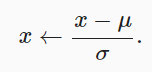

- Để kiểm tra xem công thức trên có chuyển đổi x thành dữ liệu với trung bình bằng 0 hay không thì ta có thể tính:
    + E[(x - nguy)/sigma] = (nguy - nguy)/sigma = 0
- Với phương sai:
    + E[(x - nguy)^2] = sigma ^ 2
- Như vậy biến chuyển đổi sẽ có phương sai đơn vị.

- Lý do của việc chuẩn hóa dữ liệu là do ta KHÔNG THỂ BIẾT TRƯỚC ĐẶC TRƯNG NÀO LÀ ĐẶC TRƯNG QUAN TRỌNG.

In [64]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
   MSSubClass MSZoning  LotFrontage   LotArea    YrSold SaleType SaleCondition
0    0.067320       RL    -0.184443 -0.217841  0.157619       WD        Normal
1   -0.873466       RL     0.458096 -0.072032 -0.602858       WD        Normal
2    0.067320       RL    -0.055935  0.137173  0.157619       WD        Normal
3    0.302516       RL    -0.398622 -0.078371 -1.363335       WD       Abnorml
4    0.067320       RL    

- Tiếp theo ta sẽ xử lý các giá trị rời rạc như biến MSZoning. Ta sẽ thay thế chúng bằng biểu diễn one-hit theo đúng cách ta đã chuyển đổi dữ liệu phân loại đa lớp thành vector chứa 0 và 1. 
- Ví dụ, MSZoning bao gồm các giá trị RL và RM tương ứng lần lượt với vector (1, 0) và (0, 1). Việc này được thực hiện tự động trong pandas

In [65]:
# Dummy_na = True refers to a missing values being a legal eigenvalues and 
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)
print(all_features.iloc[0:10, [0, -3, -2, -1]])

(2919, 331)
   MSSubClass  SaleCondition_Normal  SaleCondition_Partial  SaleCondition_nan
0    0.067320                     1                      0                  0
1   -0.873466                     1                      0                  0
2    0.067320                     1                      0                  0
3    0.302516                     0                      0                  0
4    0.067320                     1                      0                  0
5   -0.167877                     1                      0                  0
6   -0.873466                     1                      0                  0
7    0.067320                     1                      0                  0
8   -0.167877                     0                      0                  0
9    3.124875                     1                      0                  0
